# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pickle
import re
import sys
import warnings

import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sqlalchemy import create_engine

nltk.download(["punkt", "stopwords"])
warnings.simplefilter("ignore")

[nltk_data] Downloading package punkt to /home/roger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/roger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# load data from database
engine = create_engine("sqlite:///disaster_response.db")
df = pd.read_sql("SELECT * FROM messages", engine)
X = df["message"]
# `child_alone` is dropped due to 100% of its value is 0
Y = df.drop(["id", "message", "original", "genre", "child_alone"], axis=1)

# set random seed for this notebook
np.random.seed(95130)

### 2. Write a tokenization function to process your text data

In [3]:
def tokenize(text):
    """Normalize, tokenize and stem text string
    
    Args:
    text: string. String containing message for processing
       
    Returns:
    stemmed: list of strings. List containing normalized and stemmed word tokens
    """
    # Convert text to lowercase and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

    # Tokenize words
    tokens = word_tokenize(text)

    # Stem word tokens and remove stop words
    stemmer = PorterStemmer()
    stop_words = stopwords.words("english")

    stemmed = [stemmer.stem(word) for word in tokens if word not in stop_words]

    return stemmed

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [4]:
rf_pipe = Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=tokenize)),
        ("tfidf", TfidfTransformer()),
        (
            "clf",
            MultiOutputClassifier(RandomForestClassifier(random_state=1, n_jobs=-1)),
        ),
    ]
)

### 4. Train pipeline
- Split data into train and test sets
-Train pipeline

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
rf_pipe.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                                                                        ccp_alpha=0.0,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                   

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [6]:
# Make predictions on the training data
Y_train_pred = rf_pipe.predict(X_train)
Y_test_pred = rf_pipe.predict(X_test)

In [7]:
def display_score(y_true, y_pred):
    """helper function to display the classification_report in DataFrame format
    for all categories"""
    report_dict = classification_report(
        y_true, y_pred, output_dict=True, target_names=y_true.columns
    )
    return pd.DataFrame(report_dict).T[:-3]


display_score(Y_test, Y_test_pred)

,precision,recall,f1-score,support
related,0.835658,0.955013,0.891358,4957.0
request,0.863299,0.512798,0.643411,1133.0
offer,0.000000,0.000000,0.000000,35.0
aid_related,0.764848,0.695956,0.728778,2720.0
medical_help,0.544304,0.082375,0.143095,522.0
medical_products,0.774194,0.071429,0.130790,336.0
search_and_rescue,0.750000,0.060914,0.112676,197.0
security,0.500000,0.007463,0.014706,134.0
military,0.576923,0.071090,0.126582,211.0
water,0.882682,0.368298,0.519737,429.0


- the micro average score (which calculates metrics globally by counting the total true positives, false negatives and false positives) will be used and focused on to evaluate the performance of the machine learning model.
- Certain categories have 0 value in precision, recall, and f1 scores. They correspond to the low support value. In other words, the portion of the data with value of 1 in these categories are so small and the trained model does not make any positive predictions that are true positives. (See plot below)
- We will explore other options to improve the model in the following sections of this notebook.

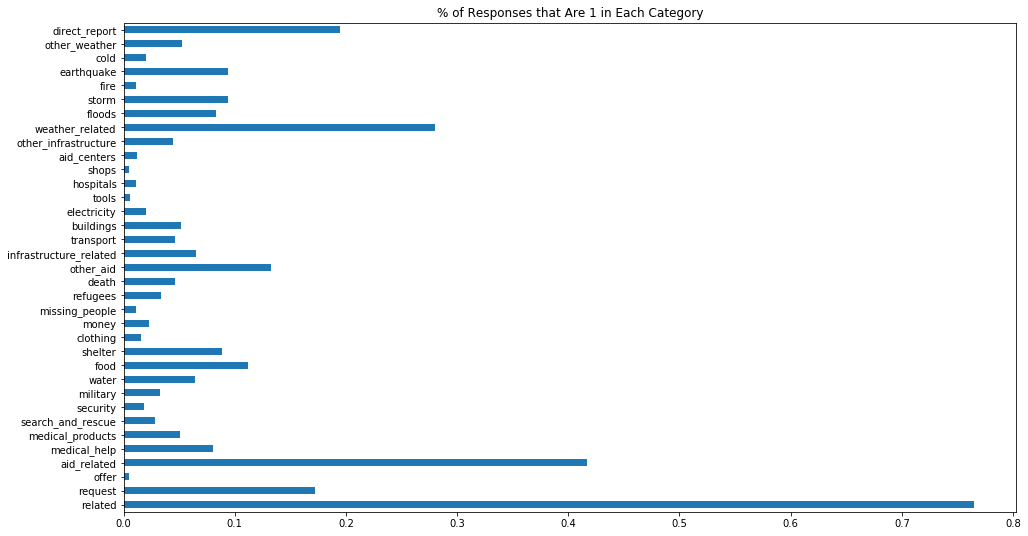

In [8]:
# plot the porpotion of response value of 1 in each response category in the data set
cat_portion_df = Y.sum() / len(Y)
cat_portion_df.plot.barh(
    title="% of Responses that Are 1 in Each Category", figsize=(16, 9),
)

### 6. Improve your model

Use grid search to find better parameters. 

In [9]:
parameters = {
    "vect__max_df": (0.75, 1.0),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
}
cv = GridSearchCV(rf_pipe, parameters, n_jobs=-1, verbose=10, cv=3, scoring="f1_micro")

In [10]:
cv.fit(X_train, Y_train)
cv_pred = cv.predict(X_test)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:  5.4min remaining: 16.3min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:  5.5min remaining:  7.7min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  9.5min remaining:  6.8min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  9.5min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  9.5min finished


In [11]:
best_parameters = cv.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

	vect__max_df: 0.75
	vect__ngram_range: (1, 1)


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [12]:
display_score(Y_test, cv_pred)

,precision,recall,f1-score,support
related,0.835658,0.955013,0.891358,4957.0
request,0.863299,0.512798,0.643411,1133.0
offer,0.000000,0.000000,0.000000,35.0
aid_related,0.764848,0.695956,0.728778,2720.0
medical_help,0.544304,0.082375,0.143095,522.0
medical_products,0.774194,0.071429,0.130790,336.0
search_and_rescue,0.750000,0.060914,0.112676,197.0
security,0.500000,0.007463,0.014706,134.0
military,0.576923,0.071090,0.126582,211.0
water,0.882682,0.368298,0.519737,429.0


* There is no significant improvement in model performance when compared to the original RandomForestClassification model.

### 8. Try improving your model further. 

* We will run the SVM and Logistic Regressions models with stochastic gradient descent (SGD) learning.

In [13]:
# create base SGD pipeline
SGD_pipe = Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=tokenize)),
        ("tfidf", TfidfTransformer()),
        ("clf", MultiOutputClassifier(SGDClassifier(random_state=1)),),
    ]
)

# grid search parameters
parameters = {
    "vect__max_df": (0.5, 0.75, 1.0),
    "vect__ngram_range": ((1, 1), (1, 2)),
    "tfidf__norm": ("l1", "l2"),
    "clf__estimator__max_iter": (100, 500, 1000),
    "clf__estimator__alpha": (0.00001, 0.000001),
    "clf__estimator__penalty": ("l2", "elasticnet"),
    # hinge = linear SVM, log = logistic regression
    "clf__estimator__loss": ("hinge", "log"),
}

In [14]:
SGD_cv = RandomizedSearchCV(SGD_pipe, parameters, n_jobs=-1, verbose=10, scoring="f1_micro")
SGD_cv.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:   59.6s remaining:   59.6s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:  1.1min remaining:   41.7s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:  1.4min remaining:   28.9s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:  1.4min remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.6min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              CountVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.int64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                                       

In [15]:
# print best parameters from GridsearchCV
best_parameters = SGD_cv.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

	clf__estimator__alpha: 1e-06
	clf__estimator__loss: 'log'
	clf__estimator__max_iter: 1000
	clf__estimator__penalty: 'elasticnet'
	tfidf__norm: 'l2'
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)


In [16]:
# print the highest f1-micro score
SGD_cv.best_score_

0.6898893672535734

In [17]:
Y_SGDcv_pred = SGD_cv.predict(X_test)

In [18]:
GSD_score = display_score(Y_test, Y_SGDcv_pred)

In [19]:
final_model = SGD_cv.best_estimator_.fit(X_train, Y_train)

In [20]:
# test prediction
msg = ["someone is hurting! help! it's burning down quick!"]
msg_cat = final_model.predict(msg)
Y_train.columns.values[(msg_cat.flatten() == 1)]

array(['related', 'request', 'aid_related', 'medical_help', 'other_aid',
       'direct_report'], dtype=object)

### 9. Export your model as a pickle file

In [21]:
pickle.dump(final_model, open("classifier.pkl", "wb"))